In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import concatenate
import math
from math import sqrt
import random
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib import pylab as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from keras.optimizers import Adam

from tensorflow.keras.layers import Flatten

import joblib
from google.colab import files
import matplotlib.dates as mdates


In [2]:
import tensorflow as tf

seed = 311
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# To enforce determinism on operations
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
daily = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alone/Cauquenes7336001__.csv')

daily.head()

,P_mm,Tmx_degC,Tmn_degC,PET_mm,Qobs_mm,Qobs_m3s,Date
0,0.0,24.923411,11.023331,5.541,0.130969,0.943,1979-01-01
1,0.0,26.041955,11.184346,5.827,0.120553,0.868,1979-01-02
2,0.0,27.163775,11.941578,6.044,0.118886,0.856,1979-01-03
3,0.0,27.528073,12.264598,6.100,0.109442,0.788,1979-01-04
4,0.0,26.982496,12.659137,5.890,0.108331,0.780,1979-01-05


In [5]:
#We select data period without missing values

plui = daily.iloc[7305:8766, 0].to_numpy()
etp = daily.iloc[7305:8766, 3].to_numpy()
discharge = daily.iloc[7305:8766, 4].to_numpy()

In [6]:
discharge[0]

np.float64(0.0134718960116209)

In [7]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR4J_HyMoLAP

In [8]:
#Percolation

def Percolation(Pn, En, X1):
   n = len(Pn)
   S = np.zeros(n)
   S[0] =  Pn[0]

   Perc = np.zeros(n)
   ratio = (4.0 / 9.0) * (S[0] / X1)
   Perc[0] = S[0] * (1 - (1 + ratio**4) ** (-0.25))

   Pr = np.zeros(n)
   Pr[0] = Perc[0] + Pn[0]

   for i in range(1, n):
        temp = (S[i-1] / X1) ** 2
        frac = Pn[i] / X1
        Ps = X1 * (1 - temp) * np.tanh(frac) / (1 + (S[i-1] / X1) * np.tanh(frac))

        frac = En[i] / X1
        Es = S[i-1] * (2 - S[i-1] / X1) * np.tanh(frac) / (1 + (1 - S[i-1] / X1) * np.tanh(frac))

        S[i] = S[i-1] + Ps - Es

        ratio = (4.0 / 9.0) * (S[i] / X1)
        Perc[i] = S[i] * (1 - (1 + ratio**4) ** (-0.25))

        Pr[i] = Perc[i] + Pn[i] - Ps

   return Perc

In [12]:
#Calibration
Pn = plui - etp
Pn[Pn < 0] = 0

En = etp - plui
En[En < 0] = 0

#  model
nse = -100
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]
Q1 = np.zeros(len(discharge))

for pp in range(1): #range(20000):
      mu = 1.0876190199933156 #(1.5 - 0.7) * np.random.rand() + 0.7
      lambda_ = 3.7565491745434856 #(10 - 0.1) * np.random.rand() + 0.1
      X1 = 291.8694529794576 #(350 - 250) * np.random.rand() + 250

      Perc = Percolation(Pn, En, X1)

      for k in range(len(discharge)-1):

          Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Perc[k] * Pn[k]


      #Nsh criteria
      nsee =  nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
      if nsee > nse:
          nse = nsee
          mu1 = mu
          lambda1 = lambda_
          X11 = X1
          GR4J_HyM = Qsim.copy()


print(nse)

0.764711330263331


In [13]:
print(mu1)
print(lambda1)
print(X11)

1.0876190199933156
3.7565491745434856
291.8694529794576


In [14]:
print('nashe=',nash_sutcliffe_efficiency(discharge[1:], GR4J_HyM[1:]))
print('rmse=',calculate_rmse(discharge[1:], GR4J_HyM[1:]))
print('r2=',calculate_r2(discharge[1:], GR4J_HyM[1:]))

nashe= 0.764711330263331
rmse= 3.031214488067131
r2= 0.7667881114831753


Validation

In [15]:
discharge1 = daily.iloc[8766:9862, 4].to_numpy()
plui1 = daily.iloc[8766:9862, 0].to_numpy()
etp1 = daily.iloc[8766:9862, 3].to_numpy()

In [16]:
Pn1 = plui1 - etp1
Pn1[Pn1 < 0] = 0

En1 = etp1 - plui1
En1[En1 < 0] = 0

In [17]:
# Simulation
size = len(discharge1)
Perc1 = Percolation(Pn1, En1, X11)

#EQUATION
Qval = np.zeros(size)
Qval[0] = discharge1[0]

for k in range(0, size-1):

    Qval[k+1] = Qval[k] - (mu1/lambda1) * Qval[k]**(2*mu1-1) +  (1/lambda1) * Perc1[k] * Pn1[k]

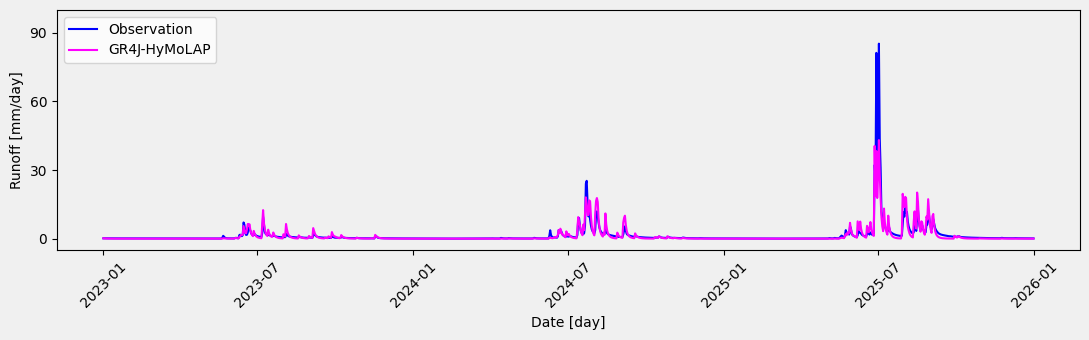

In [18]:
# Generate dates
time1 = np.datetime64('2023-01-01')
time2 = np.datetime64('2025-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated runoff
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, Qval, 'magenta', label='GR4J-HyMoLAP', linewidth=1.5)

# X-axis settings (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis settings
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-5, 100)
ax.set_yticks(np.arange(0, 101, 30))

# Add legend
ax.legend(loc='upper left')

# Show grid
#plt.grid(True)

# Avoid overlap
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_GR4J-HyMoLAP.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_GR4J-HyMoLAP.jpeg")

# Display plot
plt.show()


In [19]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], Qval[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[1:], Qval[1:])
print('rmse=', rmse)

r2 = calculate_r2(discharge1[1:], Qval[1:])
print('r2=', r2)

Nash-Sutcliffe Efficiency (NSE): 0.7521736716358391
rmse= 2.3357670329673583
r2= 0.759660311239022


Hybrid HyMoLAP_GR4J_CNN

In [20]:
def split_train_test(values, n_train_hours = 1460):
    # Split the data into train (use values before n_train_hours) and test sets (use values after n_train_hours)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features] required for LSTM
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y

In [21]:
def history_and_horizon_sequencing(df, n_history, n_horizon, target='debits'):
    # Separate inputs (e.g., precipitation, ETP) from targets (e.g., discharge)
    input_columns = [col for col in df.columns if col != target]
    df_inputs = df[input_columns]
    df_target = df[target].to_frame()

    # History: past sequences (t-n, ... t-1) for inputs (e.g., precipitation, ETP)
    stack_history = []
    for i in range(n_history, 0, -1):
        df_i = df_inputs.shift(i)
        df_i.columns = [f'{col}_t-{i}' for col in df_i.columns]
        stack_history.append(df_i)

    # Present: t for inputs
    df_t = df_inputs.copy()
    df_t.columns = [f'{col}_t' for col in df_t.columns]

    # Horizon: future sequences (t+1, ... t+n) for targets (e.g., discharge)
    stack_horizon = []
    for j in range(0, n_horizon):
        df_j = df_target.shift(-j)
        df_j.columns = [f'{col}_t+{j}' for col in df_j.columns]
        stack_horizon.append(df_j)

    # Return the concatenated DataFrame: past + present + future (inputs and targets)
    return pd.concat(stack_history + [df_t] + stack_horizon, axis=1)

In [22]:
# Create DataFrame for training (calibration)
data_train = pd.DataFrame({
    'perc': Perc,
    'Qsim': GR4J_HyM,
    'prec': plui,
    'pet': etp,

    'target': discharge
})

# Create DataFrame for validation (test)
data_test = pd.DataFrame({
    'perc': Perc1,
    'Qsim': Qval,
    'prec': plui1,
    'pet': etp1,

    'target': discharge1
})

# Concatenate the two DataFrames (calibration + validation)
data = pd.concat([data_train, data_test], ignore_index=True)


In [23]:
#Include look_back
look_back = 0
horizon = 1     # To correspond to the same day (t) as the inputs

data_Xy = history_and_horizon_sequencing(data, look_back, horizon, target='target')
data_Xy.dropna(inplace=True)

#split data
train_X, train_y, test_X, test_y = split_train_test(data_Xy.values, 1461)


(1461, 1, 4) (1461,) (1096, 1, 4) (1096,)


In [24]:
data_Xy

,perc_t,Qsim_t,prec_t,pet_t,target_t+0
0,0.000000,0.013472,0.0,6.078,0.013472
1,0.000000,0.011638,0.0,5.798,0.012639
2,0.000000,0.010094,0.0,5.189,0.012083
3,0.000000,0.008788,0.0,5.422,0.011250
4,0.000000,0.007678,0.0,5.425,0.010694
...,...,...,...,...,...
2552,0.000203,0.002357,0.0,4.470,0.102775
2553,0.000169,0.002120,0.0,5.784,0.103331
2554,0.000143,0.001912,0.0,5.255,0.106942
2555,0.000120,0.001727,0.0,5.450,0.104720


In [25]:
def build_1d_cnn_model(input_shape, nb_filters=64, kernel_size=1, pool_size=1):
    '''
    Construction d'un modèle 1D-ConvNet avec deux couches Conv1D
    '''
    model = Sequential()

    # Première couche Conv1D
    model.add(Conv1D(filters=nb_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))

    # Flatten avant la couche Dense
    model.add(Flatten())

    # Couche Dense de sortie
    model.add(Dense(units=1))

    # Compilation du modèle
    model.compile(loss='mse', optimizer='adam')

    return model


def train_model(model, train_X, train_y, test_X, test_y, epochs=200, batch_size=256, verbose=0):
#def train_model(model, train_X, train_y, test_X, test_y, epochs=150, batch_size=128, verbose=0):
    '''
    Fonction générique pour entraîner le modèle
    '''
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=verbose, shuffle=True)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

Simulation with Scaling data

In [26]:
# Normalize features
values = data_Xy.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
# Create train/tests datasets from scaled_data
scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values, 1461)

(1461, 1, 4) (1461,) (1096, 1, 4) (1096,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


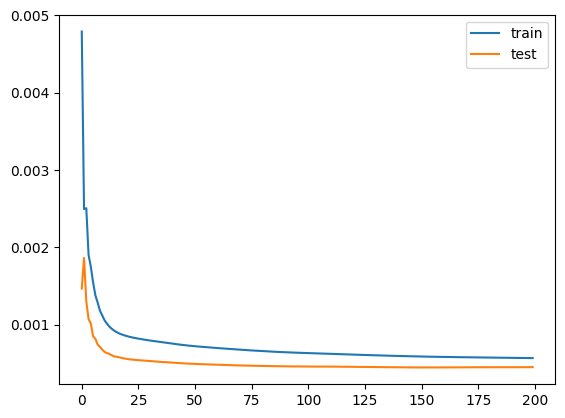

In [27]:
# Build and train the model
input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])
# Build and train the model using the build_lstm_model (new instance name lstm_model_scaled)
Con_lstm_model_scaled = build_1d_cnn_model(input_shape, nb_filters=64, kernel_size=1, pool_size=1)
# Train the new model using train_model method as previousely using the new scaled data
train_model(Con_lstm_model_scaled, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y)

In [28]:
# invert scaling for forecast
def invert_scaling(scaled_X, scaled_yhat):
  scaled_tX = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = concatenate((scaled_tX, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]


In [29]:
# make a prediction on train
sca_train_pred_yhat = Con_lstm_model_scaled.predict(scaled_train_X)
#
sca_inv_yhat = invert_scaling(scaled_train_X, sca_train_pred_yhat)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [30]:
# Trianing Performance evaluation
sca_train_pred_flat = sca_inv_yhat.flatten()

nse_value = nash_sutcliffe_efficiency(discharge[1:], sca_train_pred_flat[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge[1:], sca_train_pred_flat[1:])
print('RMSE =', rmse)

r2 = calculate_r2(discharge[1:], sca_train_pred_flat[1:])
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8628185506525151
RMSE = 2.314535542767298
R² = 0.8629780661860932


In [31]:
# make a prediction on test
sca_test_pred_yhat = Con_lstm_model_scaled.predict(scaled_test_X)
#
sca_inv_yhat = invert_scaling(scaled_test_X, sca_test_pred_yhat)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [32]:
# Validation Performance evaluation
sca_test_pred_flat = sca_inv_yhat.flatten()

nse_value = nash_sutcliffe_efficiency(discharge1[1:], sca_test_pred_flat[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[1:], sca_test_pred_flat[1:])
print('RMSE =', rmse)

r2 = calculate_r2(discharge1[1:], sca_test_pred_flat[1:])
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8053743481284448
RMSE = 2.0699308785565957
R² = 0.8561746303374732


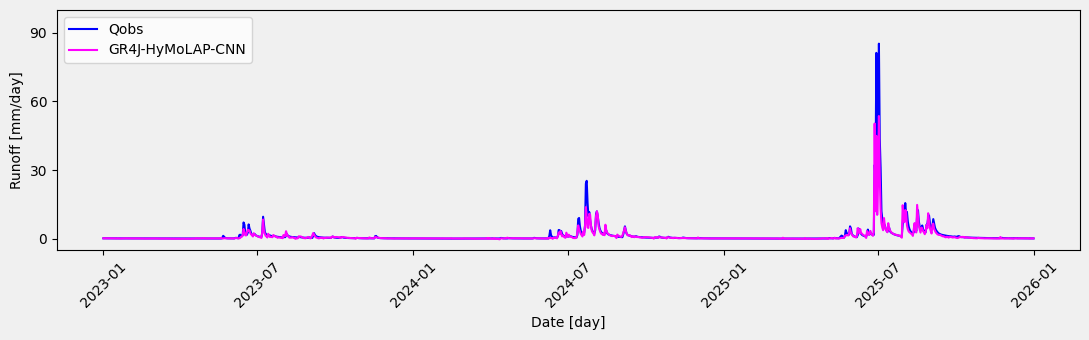

In [33]:
# Generate dates from 2023-01-01 to 2025-12-31
time1 = np.datetime64('2023-01-01')
time2 = np.datetime64('2025-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Set background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated runoff
ax.plot(time, discharge1, 'b', label='Qobs')
ax.plot(time, sca_test_pred_flat, 'magenta', label='GR4J-HyMoLAP-CNN')

# Configure x-axis (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Configure y-axis
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-5, 100)
ax.set_yticks(np.arange(0, 101, 30))

# Add legend
ax.legend(loc='upper left')

# Show grid (commented out)
# plt.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save figure with high resolution
plt.savefig("Cauqueness_GR4J-HyMoLAP-CNN.jpeg", format='jpeg', dpi=700)

# Uncomment to download the file in Colab environment
# files.download("Cauqueness_GR4J-HyMoLAP-CNN.jpeg")

# Display the plot
plt.show()
